# EYE FOR BLIND
This notebook will be used to prepare the capstone project 'Eye for Blind'

In [1]:
#Import all the required libraries

import os
import numpy as np
import cv2
import glob
import imutils
import pandas as pd
import matplotlib.pyplot as plt
import random
from function import *
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.applications import vgg16
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from collections import Counter

2023-05-16 11:31:37.844705: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-05-16 11:31:37.844722: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Let's read the dataset

## Data understanding
1.Import the dataset and read image & captions into two seperate variables

2.Visualise both the images & text present in the dataset

3.Create a dataframe which summarizes the image, path & captions as a dataframe

4.Create a list which contains all the captions & path

5.Visualise the top 30 occuring words in the captions



In [2]:
#Import the dataset and read the image into a seperate variable

data_dir='../data'

all_imgs = glob.glob(data_dir + '/Images/*.jpg',recursive=True)
print("The total images present in the dataset: {}".format(len(all_imgs)))

The total images present in the dataset: 8091


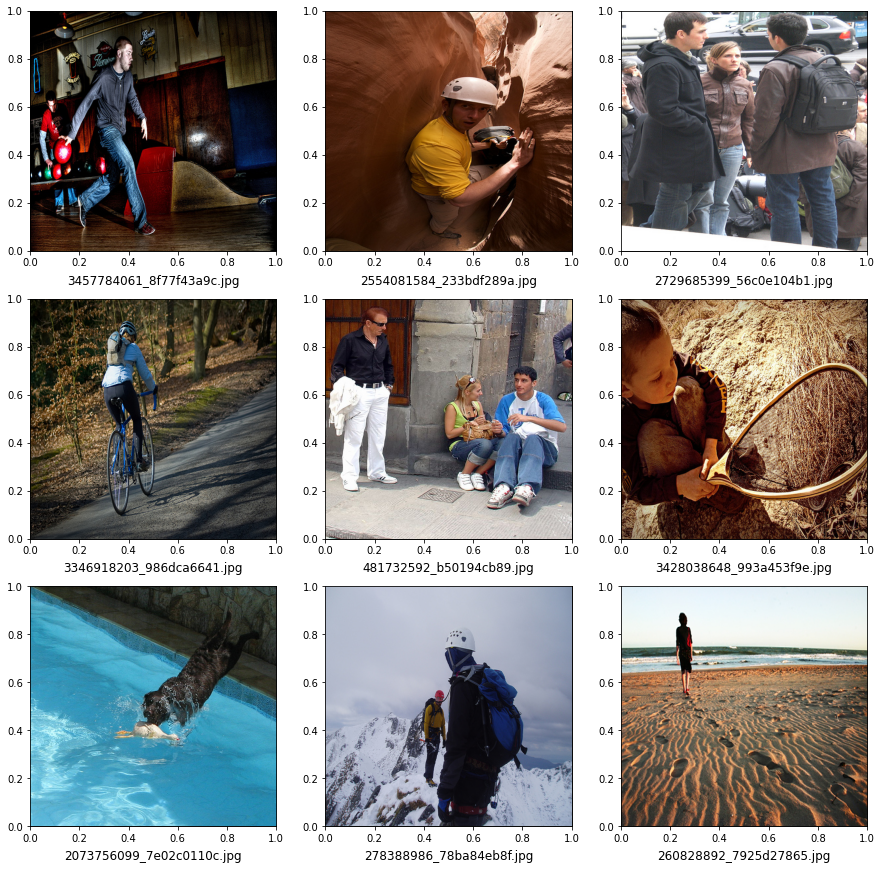

In [3]:
#Visualise both the images & text present in the dataset

show_img(3,3, all_imgs)

In [4]:
#Import the dataset and read the text file into a seperate variable
def load_doc():
    df_cap = pd.read_csv(data_dir+'/captions.txt', sep = ',')
    return df_cap

df_cap = load_doc()
df_cap.head()

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...


Create a dataframe which summarizes the image, path & captions as a dataframe

Each image id has 5 captions associated with it therefore the total dataset should have 40455 samples.

In [5]:
images_path = os.path.abspath(data_dir)+'/Images'
all_img_vector = [images_path+'/'+df_cap['image'][i] for i in range(len(df_cap))]
all_img_vector[:5]

['/home/dev/Xavier/importance/eye_for_blind/data/Images/1000268201_693b08cb0e.jpg',
 '/home/dev/Xavier/importance/eye_for_blind/data/Images/1000268201_693b08cb0e.jpg',
 '/home/dev/Xavier/importance/eye_for_blind/data/Images/1000268201_693b08cb0e.jpg',
 '/home/dev/Xavier/importance/eye_for_blind/data/Images/1000268201_693b08cb0e.jpg',
 '/home/dev/Xavier/importance/eye_for_blind/data/Images/1000268201_693b08cb0e.jpg']

In [6]:
df_cap['Path'] = all_img_vector
df_cap.head()

,image,caption,Path
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...,/home/dev/Xavier/importance/eye_for_blind/data...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .,/home/dev/Xavier/importance/eye_for_blind/data...
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .,/home/dev/Xavier/importance/eye_for_blind/data...
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...,/home/dev/Xavier/importance/eye_for_blind/data...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...,/home/dev/Xavier/importance/eye_for_blind/data...


In [7]:
df_cap = df_cap[['image', 'Path', 'caption']]
df_cap = df_cap.rename(columns={'image': 'ID', 'caption': 'Captions'})

df_cap.head()

,ID,Path,Captions
0,1000268201_693b08cb0e.jpg,/home/dev/Xavier/importance/eye_for_blind/data...,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,/home/dev/Xavier/importance/eye_for_blind/data...,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,/home/dev/Xavier/importance/eye_for_blind/data...,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,/home/dev/Xavier/importance/eye_for_blind/data...,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,/home/dev/Xavier/importance/eye_for_blind/data...,A little girl in a pink dress going into a woo...


In [8]:
#Create a list which contains all the captions
df_cap['Captions'] = df_cap['Captions'].apply(lambda x: standardize(x))
annotations=df_cap['Captions']
annotations[:5]

2023-05-16 11:31:40.840489: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-05-16 11:31:40.840509: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-05-16 11:31:40.840527: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (Tech-thaipv): /proc/driver/nvidia/version does not exist
2023-05-16 11:31:40.840831: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


0    <START> a child in a pink dress is climbing up...
1    <START> a girl going into a wooden building  <...
2    <START> a little girl climbing into a wooden p...
3    <START> a little girl climbing the stairs to h...
4    <START> a little girl in a pink dress going in...
Name: Captions, dtype: object

In [9]:
all_img_path=df_cap['Path']

print("Total captions present in the dataset: "+ str(len(annotations)))
print("Total images present in the dataset: " + str(len(all_img_path)))

Total captions present in the dataset: 40455
Total images present in the dataset: 40455


In [10]:
#Create the vocabulary & the counter for the captions

vocabulary=[word.lower() for line in annotations for word in line.split()]

val_count=Counter(vocabulary)
val_count.most_common(32)

[('a', 62986),
 ('<start>', 40455),
 ('<end>', 40455),
 ('in', 18974),
 ('the', 18418),
 ('on', 10743),
 ('is', 9345),
 ('and', 8851),
 ('dog', 8136),
 ('with', 7765),
 ('man', 7265),
 ('of', 6713),
 ('two', 5638),
 ('white', 3940),
 ('black', 3832),
 ('boy', 3581),
 ('are', 3504),
 ('woman', 3402),
 ('girl', 3328),
 ('to', 3173),
 ('wearing', 3062),
 ('at', 2914),
 ('people', 2883),
 ('water', 2783),
 ('red', 2672),
 ('young', 2630),
 ('brown', 2563),
 ('an', 2432),
 ('his', 2357),
 ('blue', 2268),
 ('dogs', 2125),
 ('running', 2073)]

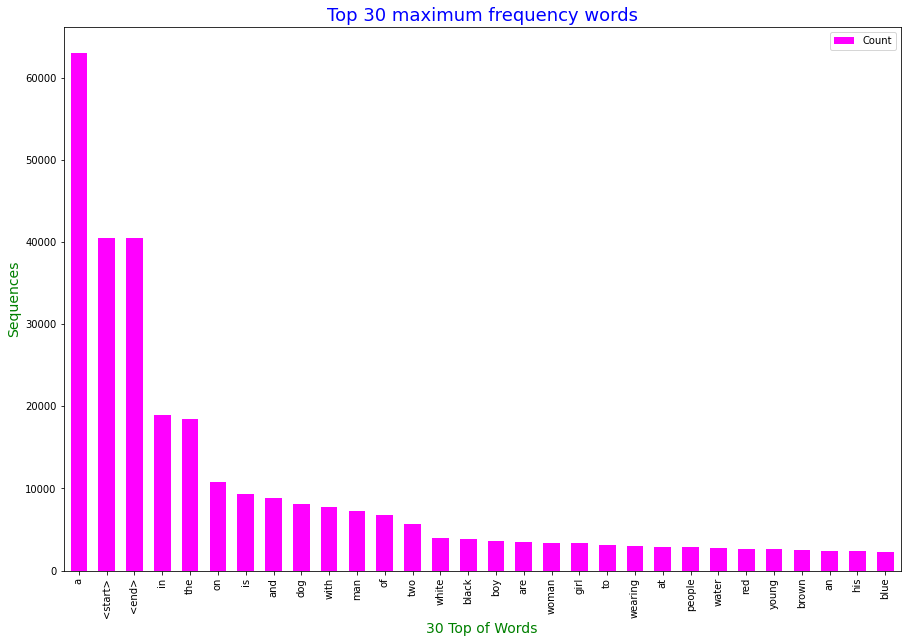

In [11]:
#Visualise the top 30 occuring words in the captions

most_top_word(val_count, ntop=30)

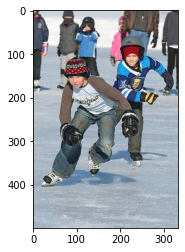

<START> children skating while people watch on the side  <END>
<START> two boys ice skate with other people  <END>
<START> two boys on ice skates race on an outdoor ice rink  <END>
<START> two boys race on ice skates while others watch  <END>
<START> two children are skating quickly on ice  <END>


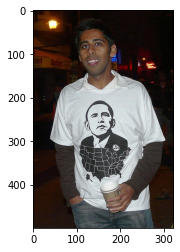

<START> a man wearing a barack obama shirt smiles for the camera <END>
<START> a man wearing an obama tshirt and holding a coffee cup  <END>
<START> a young man touts an obama tshirt  <END>
<START> this is a man holding a cup and wearing an obama tshirt  <END>
<START> this man is wearing a barack obama tshirt and carrying a drink  <END>


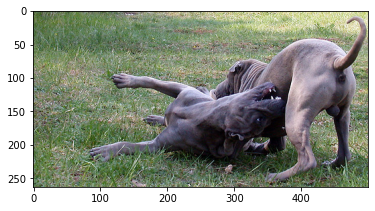

<START> a brown dog is in a grassy field twisting itself around to see underneath itself  <END>
<START> two big brow dogs who look alike wrestle  <END>
<START> two dogs are playing in a grassy field  <END>
<START> two dogs play with each other in the grass  <END>
<START> two grey dogs fight  <END>


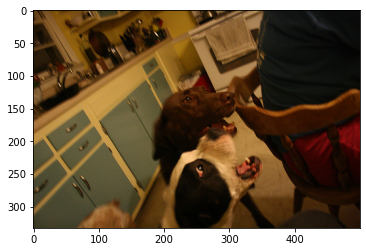

<START> two dogs are barking in a kitchen while a person sits at a table  <END>
<START> two dogs are waiting to be fed in the kitchen  <END>
<START> two dogs are waiting with their mouths open by a person sat in a dining room chair  <END>
<START> two dogs bark at a man in a chair  <END>
<START> two dogs begging a partially seen person for food at a kitchen table  <END>


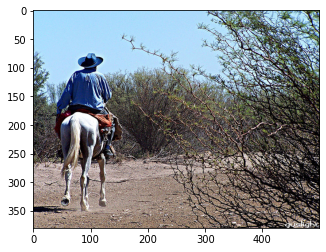

<START> a man in a blue cowboy hat is riding a white horse  <END>
<START> a man in blue is riding a horse on a dirt road  <END>
<START> a man wearing a blue hat and shirt is riding a white horse  <END>
<START> a person in a blue cowboy hat rides a horse down a dirt trail  <END>
<START> the person in the blue shirt and blue hat is riding a white horse  <END>


In [12]:
# Show captions and Image
show_img_desc(df_cap)

## Pre-Processing the captions
1.Create the tokenized vectors by tokenizing the captions fore ex :split them using spaces & other filters. 
This gives us a vocabulary of all of the unique words in the data. Keep the total vocaublary to top 5,000 words for saving memory.

2.Replace all other words with the unknown token "UNK" .

3.Create word-to-index and index-to-word mappings.

4.Pad all sequences to be the same length as the longest one.

In [13]:
# create the tokenizer
top_word_cnt = 5000
tokenizer = Tokenizer(num_words = top_word_cnt+1, filters= '!"#$%^&*()_+.,:;-?/~`{}[]|\=@ ',
                      lower = True, char_level = False, 
                      oov_token = 'UNK')
tokenizer.index_docs

defaultdict(int, {})

In [14]:
tokenizer.index_word

{}

In [15]:
# Create word-to-index and index-to-word mappings.
tokenizer.fit_on_texts(annotations)

#transform each text into a sequence of integers
text_to_cvt = ['a wide river with many small waterfalls',
               'a sled dog pulling a blue toy excavator in the snow']
print(tokenizer.texts_to_sequences(text_to_cvt))

[[2, 679, 227, 11, 268, 53, 2559], [2, 375, 10, 392, 2, 31, 105, 1, 5, 6, 45]]


In [16]:
train_seqs = tokenizer.texts_to_sequences(annotations)
train_seqs[:5]

[[3, 2, 43, 5, 2, 91, 171, 8, 120, 54, 2, 396, 13, 393, 5, 29, 1, 694, 4],
 [3, 2, 20, 315, 65, 2, 195, 118, 4],
 [3, 2, 41, 20, 120, 65, 2, 195, 2432, 4],
 [3, 2, 41, 20, 120, 6, 393, 21, 61, 2432, 4],
 [3, 2, 41, 20, 5, 2, 91, 171, 315, 65, 2, 195, 2995, 4]]

In [17]:
# Get the top 10 key-value pairs
top_10 = {k: tokenizer.index_word[k] for k in list(tokenizer.index_word.keys())[:10]}
top_10

{1: 'UNK',
 2: 'a',
 3: '<start>',
 4: '<end>',
 5: 'in',
 6: 'the',
 7: 'on',
 8: 'is',
 9: 'and',
 10: 'dog'}

In [18]:
tokenizer.word_index['PAD'] = 0
tokenizer.index_word[0] = 'PAD'

tokenizer.index_word = dict(sorted(tokenizer.index_word.items()))

# Get the top 10 key-value pairs
top_10 = {k: tokenizer.index_word[k] for k in list(tokenizer.index_word.keys())[:10]}
top_10

{0: 'PAD',
 1: 'UNK',
 2: 'a',
 3: '<start>',
 4: '<end>',
 5: 'in',
 6: 'the',
 7: 'on',
 8: 'is',
 9: 'and'}

In [19]:
print(tokenizer.oov_token)
print(tokenizer.index_word[0])

UNK
PAD


In [20]:
# Create a word count of your tokenizer to visulize the Top 30 occuring words after text processing
tokenizer_top_words = [word for line in annotations for word in line.split() ]

#tokenizer_top_words_count
tokenizer_top_words_count = Counter(tokenizer_top_words)
tokenizer_top_words_count.most_common(30)

[('a', 62986),
 ('<START>', 40455),
 ('<END>', 40455),
 ('in', 18974),
 ('the', 18418),
 ('on', 10743),
 ('is', 9345),
 ('and', 8851),
 ('dog', 8136),
 ('with', 7765),
 ('man', 7265),
 ('of', 6713),
 ('two', 5638),
 ('white', 3940),
 ('black', 3832),
 ('boy', 3581),
 ('are', 3504),
 ('woman', 3402),
 ('girl', 3328),
 ('to', 3173),
 ('wearing', 3062),
 ('at', 2914),
 ('people', 2883),
 ('water', 2783),
 ('red', 2672),
 ('young', 2630),
 ('brown', 2563),
 ('an', 2432),
 ('his', 2357),
 ('blue', 2268)]

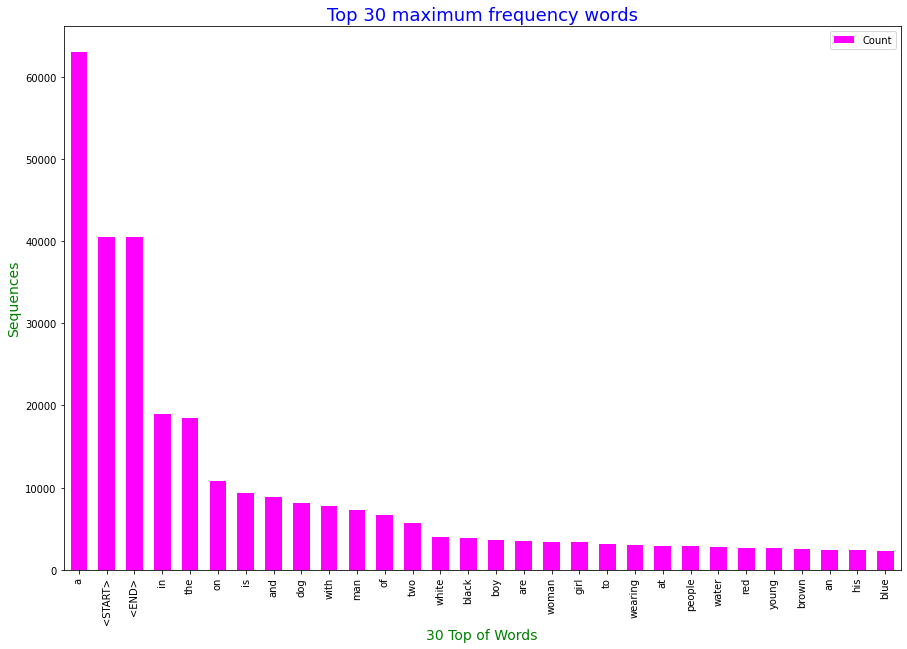

In [21]:
most_top_word(tokenizer_top_words_count, ntop=30)

In [22]:
# Pad each vector to the max_length of the captions ^ store it to a vairable

train_seqs_len = [len(seq) for seq in train_seqs]
longest_word_length = max(train_seqs_len)
cap_vector= tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding= 'post', maxlen = longest_word_length,
                                                          dtype='int32', value=0)

print("The shape of Caption vector is :" + str(cap_vector.shape))

The shape of Caption vector is :(40455, 38)


In [28]:
print(annotations[0])
print(train_seqs[0])
print(cap_vector[0])

<START> a child in a pink dress is climbing up a set of stairs in an entry way  <END>
[3, 2, 43, 5, 2, 91, 171, 8, 120, 54, 2, 396, 13, 393, 5, 29, 1, 694, 4]
[  3   2  43   5   2  91 171   8 120  54   2 396  13 393   5  29   1 694
   4   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0]


## Pre-processing the images

1.Resize them into the shape of (299, 299)

3.Normalize the image within the range of -1 to 1, such that it is in correct format for InceptionV3. 

### FAQs on how to resize the images::
* Since you have a list which contains all the image path, you need to first convert them to a dataset using <i>tf.data.Dataset.from_tensor_slices</i>. Once you have created a dataset consisting of image paths, you need to apply a function to the dataset which will apply the necessary preprocessing to each image. 
* This function should resize them and also should do the necessary preprocessing that it is in correct format for InceptionV3.


In [24]:
#write your code here to create the dataset consisting of image paths

In [25]:
#write your code here for creating the function. This function should return images & their path

def load_image(image_path):
    #write your pre-processing steps here
    
    return 

In [26]:
#write your code here for applying the function to the image path dataset, such that the transformed dataset should contain images & their path





## Load the pretrained Imagenet weights of Inception net V3

1.To save the memory(RAM) from getting exhausted, extract the features of the images using the last layer of pre-trained model. Including this as part of training will lead to higher computational time.

2.The shape of the output of this layer is 8x8x2048. 

3.Use a function to extract the features of each image in the train & test dataset such that the shape of each image should be (batch_size, 8*8, 2048)



In [27]:
image_model = tf.keras.applications.InceptionV3(include_top=False,weights='imagenet')

new_input = #write code here to get the input of the image_model
hidden_layer = #write code here to get the output of the image_model

image_features_extract_model = #build the final model using both input & output layer

SyntaxError: invalid syntax (3481611691.py, line 3)

In [ ]:
# write the code to apply the feature_extraction model to your earlier created dataset which contained images & their respective paths
# Once the features are created, you need to reshape them such that feature shape is in order of (batch_size, 8*8, 2048)



### FAQs on how to store the features:
* You can store the features using a dictionary with the path as the key and values as the feature extracted by the inception net v3 model OR
* You can store using numpy(np.save) to store the resulting vector.

## Dataset creation
1.Apply train_test_split on both image path & captions to create the train & test list. Create the train-test spliit using 80-20 ratio & random state = 42

2.Create a function which maps the image path to their feature. 

3.Create a builder function to create train & test dataset & apply the function created earlier to transform the dataset

2.Make sure you have done Shuffle and batch while building the dataset

3.The shape of each image in the dataset after building should be (batch_size, 8*8, 2048)

4.The shape of each caption in the dataset after building should be(batch_size, max_len)


In [ ]:
#write your code here

path_train, path_test, cap_train, cap_test = train_test_split( #your code goes here)

In [ ]:
print("Training data for images: " + str(len(path_train)))
print("Testing data for images: " + str(len(path_test)))
print("Training data for Captions: " + str(len(cap_train)))
print("Testing data for Captions: " + str(len(cap_test)))

In [ ]:
# Create a function which maps the image path to their feature. 
# This function will take the image_path & caption and return it's feature & respective caption.

def map_func(# your input variable goes here):
  img_tensor = # write your code here to extract the features from the dictionary stored earlier
  return 

### FAQs on how to load the features:
* You can load the features using the dictionary created earlier OR
* You can store using numpy(np.load) to load the feature vector.

In [ ]:
# create a builder function to create dataset which takes in the image path & captions as input
# This function should transform the created dataset(img_path,cap) to (features,cap) using the map_func created earlier

def gen_dataset(#your input variables):
    
    # your code goes here to create the dataset & transform it
    
    
    return dataset



In [ ]:
train_dataset=gen_dataset(path_train,cap_train)
test_dataset=gen_dataset(path_test,cap_test)

In [ ]:
sample_img_batch, sample_cap_batch = next(iter(train_dataset))
print(sample_img_batch.shape)  #(batch_size, 8*8, 2048)
print(sample_cap_batch.shape) #(batch_size,max_len)

## Model Building
1.Set the parameters

2.Build the Encoder, Attention model & Decoder

In [ ]:
embedding_dim = 256 
units = 512
vocab_size = #top 5,000 words +1
train_num_steps = =#len(total train images) // BATCH_SIZE
test_num_steps = #len(total test images) // BATCH_SIZE

### Encoder

In [ ]:
class Encoder(Model):
    def __init__(self,embed_dim):
        super(Encoder, self).__init__()
        self.dense = #build your Dense layer with relu activation
        
    def call(self, features):
        features =  # extract the features from the image shape: (batch, 8*8, embed_dim)
        
        return features

In [ ]:
encoder=Encoder(embedding_dim)

### Attention model

In [ ]:
class Attention_model(Model):
    def __init__(self, units):
        super(Attention_model, self).__init__()
        self.W1 = #build your Dense layer
        self.W2 = #build your Dense layer
        self.V = #build your final Dense layer with unit 1
        self.units=units

    def call(self, features, hidden):
        #features shape: (batch_size, 8*8, embedding_dim)
        # hidden shape: (batch_size, hidden_size)
        hidden_with_time_axis =  # Expand the hidden shape to shape: (batch_size, 1, hidden_size)
        score = # build your score funciton to shape: (batch_size, 8*8, units)
        attention_weights =  # extract your attention weights with shape: (batch_size, 8*8, 1)
        context_vector =  #shape: create the context vector with shape (batch_size, 8*8,embedding_dim)
        context_vector = # reduce the shape to (batch_size, embedding_dim)
        

        return context_vector, attention_weights

### Decoder

In [ ]:
class Decoder(Model):
    def __init__(self, embed_dim, units, vocab_size):
        super(Decoder, self).__init__()
        self.units=units
        self.attention = #iniitalise your Attention model with units
        self.embed = #build your Embedding layer
        self.gru = tf.keras.layers.GRU(self.units,return_sequences=True,return_state=True,recurrent_initializer='glorot_uniform')
        self.d1 = #build your Dense layer
        self.d2 = #build your Dense layer
        

    def call(self,x,features, hidden):
        context_vector, attention_weights = #create your context vector & attention weights from attention model
        embed =  # embed your input to shape: (batch_size, 1, embedding_dim)
        embed =  # Concatenate your input with the context vector from attention layer. Shape: (batch_size, 1, embedding_dim + embedding_dim)
        output,state = # Extract the output & hidden state from GRU layer. Output shape : (batch_size, max_length, hidden_size)
        output = self.d1(output)
        output = tf.reshape(output, (-1, output.shape[2])) # shape : (batch_size * max_length, hidden_size)
        output = self.d2(output) # shape : (batch_size * max_length, vocab_size)
        
        return output,state, attention_weights
    
    def init_state(self, batch_size):
        return tf.zeros((batch_size, self.units))

In [ ]:
decoder=Decoder(embedding_dim, units, vocab_size)

In [ ]:
features=encoder(sample_img_batch)

hidden = decoder.init_state(batch_size=sample_cap_batch.shape[0])
dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * sample_cap_batch.shape[0], 1)

predictions, hidden_out, attention_weights= decoder(dec_input, features, hidden)
print('Feature shape from Encoder: {}'.format(features.shape)) #(batch, 8*8, embed_dim)
print('Predcitions shape from Decoder: {}'.format(predictions.shape)) #(batch,vocab_size)
print('Attention weights shape from Decoder: {}'.format(attention_weights.shape)) #(batch, 8*8, embed_dim)

## Model training & optimization
1.Set the optimizer & loss object

2.Create your checkpoint path

3.Create your training & testing step functions

4.Create your loss function for the test dataset

In [ ]:
optimizer = #define the optimizer
loss_object = #define your loss object

In [ ]:
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

In [ ]:
checkpoint_path = "your checkpoint path"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path_ckpt, max_to_keep=5)

In [ ]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
    start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])

* While creating the training step for your model, you will apply Teacher forcing.
* Teacher forcing is a technique where the target/real word is passed as the next input to the decoder instead of previous prediciton.

In [ ]:
@tf.function
def train_step(img_tensor, target):
    loss = 0
    hidden = decoder.reset_state(batch_size=target.shape[0])
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)
    
    with tf.GradientTape() as tape:
        #write your code here to do the training steps
        
    return loss, avg_loss

* While creating the test step for your model, you will pass your previous prediciton as the next input to the decoder.

In [ ]:
@tf.function
def test_step(img_tensor, target):
    loss = 0
    
    #write your code here to do the testing steps
        
    return loss, avg_loss

In [ ]:
def test_loss_cal(test_dataset):
    total_loss = 0

    #write your code to get the average loss result on your test data
    
    return avg_test_loss

In [ ]:
loss_plot = []
test_loss_plot = []
EPOCHS = 15

best_test_loss=100
for epoch in tqdm(range(0, EPOCHS)):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(train_dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss
        avg_train_loss=total_loss / train_num_steps
        
    loss_plot.append(avg_train_loss)    
    test_loss = test_loss_cal(test_dataset)
    test_loss_plot.append(test_loss)
    
    print ('For epoch: {}, the train loss is {:.3f}, & test loss is {:.3f}'.format(epoch+1,avg_train_loss,test_loss))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))
    
    if test_loss < best_test_loss:
        print('Test loss has been reduced from %.3f to %.3f' % (best_test_loss, test_loss))
        best_test_loss = test_loss
        ckpt_manager.save()

In [ ]:
plt.plot(loss_plot)
plt.plot(test_loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

#### NOTE: 
* Since there is a difference between the train & test steps ( Presence of teacher forcing), you may observe that the train loss is decreasing while your test loss is not. 
* This doesn't mean that the model is overfitting, as we can't compare the train & test results here, as both approach is different.
* Also, if you want to achieve better results you can run it more epochs, but the intent of this capstone is to give you an idea on how to integrate attention mechanism with E-D architecture for images. The intent is not to create the state of art model. 

## Model Evaluation
1.Define your evaluation function using greedy search

2.Define your evaluation function using beam search ( optional)

3.Test it on a sample data using BLEU score

### Greedy Search

In [ ]:
def evaluate(image):
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0) #process the input image to desired format before extracting features
    img_tensor_val = # Extract features using our feature extraction model
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = # extract the features by passing the input to encoder

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = # get the output from decoder

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = #extract the predicted id(embedded value) which carries the max value
        #map the id to the word from tokenizer and append the value to the result list

        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot,predictions

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot,predictions


### Beam Search(optional)

In [ ]:
def beam_evaluate(image, beam_index = #your value for beam index):

    #write your code to evaluate the result using beam search
                  
    return final_caption



In [ ]:
def plot_attmap(caption, weights, image):

    fig = plt.figure(figsize=(10, 10))
    temp_img = np.array(Image.open(image))
    
    len_cap = len(caption)
    for cap in range(len_cap):
        weights_img = np.reshape(weights[cap], (8,8))
        weights_img = np.array(Image.fromarray(weights_img).resize((224, 224), Image.LANCZOS))
        
        ax = fig.add_subplot(len_cap//2, len_cap//2, cap+1)
        ax.set_title(caption[cap], fontsize=15)
        
        img=ax.imshow(temp_img)
        
        ax.imshow(weights_img, cmap='gist_heat', alpha=0.6,extent=img.get_extent())
        ax.axis('off')
    plt.subplots_adjust(hspace=0.2, wspace=0.2)
    plt.show()

In [ ]:
from nltk.translate.bleu_score import sentence_bleu

In [ ]:
def filt_text(text):
    filt=['<start>','<unk>','<end>'] 
    temp= text.split()
    [temp.remove(j) for k in filt for j in temp if k==j]
    text=' '.join(temp)
    return text

In [ ]:
rid = np.random.randint(0, len(img_test))
test_image = img_test[rid]
#test_image = './images/413231421_43833a11f5.jpg'
#real_caption = '<start> black dog is digging in the snow <end>'

real_caption = ' '.join([tokenizer.index_word[i] for i in cap_test[rid] if i not in [0]])
result, attention_plot,pred_test = evaluate(test_image)


real_caption=filt_text(real_caption)      


pred_caption=' '.join(result).rsplit(' ', 1)[0]

real_appn = []
real_appn.append(real_caption.split())
reference = real_appn
candidate = pred_caption.split()

score = sentence_bleu(reference, candidate, weights=#set your weights)
print(f"BELU score: {score*100}")

print ('Real Caption:', real_caption)
print ('Prediction Caption:', pred_caption)
plot_attmap(result, attention_plot, test_image)


Image.open(test_image)

In [ ]:
captions=beam_evaluate(test_image)
print(captions)